# TOPO processing for ACCESS-Rom3 8km 

now with deseas

Correct masks!

Prerequsiste: have regrdded ice shelf topo, thickness and elevation, and ran the model in layer mode and generated initial conditions of h

Before that, ran model with depth=6000m to have area everywhere.

(`ice_shelf_panan-layer-for-masks`)

https://github.com/claireyung/mom6-panAn-iceshelf-tools/wiki/How-to-make-a-new-panan-MOM6%E2%80%90SIS2-config-with-ice-shelves#10-layer-run-to-get-grounding-line

Claire 15/9/25

In [1]:
import xesmf
import xarray as xr
import os
import cmocean as cm
import cartopy.crs as ccrs
from dask.distributed import Client
import dask.array as da
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326", always_xy=True) 


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42925,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41753,Total threads: 4
Dashboard: /proxy/40077/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:39831,


In [4]:
topog = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/topog_Charrassin_regridded.nc')
ice_thick = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/ice_thickness_Charrassin_regridded.nc')
surface = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/surface_Charrassin_regridded.nc')
water_height = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/WATER_HEIGHT_Charrassin_regridded.nc')

In [7]:
# add area to ice_thick
ice_thick_area = ice_thick.copy().sel(ny = np.arange(1442))
area = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km-SIS2/area_everywhere.nc') # RUN MODEL WITH TOPO CONSTANT AT 6000M TO GET AREA EVERYWHERE
ice_thick_area["area"] = area.Ah.rename({'lath':'ny','lonh':'nx'}).where(surface.elevation.sel(ny = np.arange(1442))>0).fillna(0)
#ice_thick_area["area"] = ice_thick_area.area.where(topo.depth>0).fillna(0)

ice_thick_area.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/ice_thickness_Charrassin_regridded_cropped_add_area_150925.nc")


## run layer mode model 
- `/home/156/cy8964/mom6-control/access-rom3/ice_shelf_panan-layer-for-masks`
- github: https://github.com/claireyung/access-om3-configs/tree/ice_shelf_panan-layer-for-masks
- commit: https://github.com/claireyung/access-om3-configs/tree/b997045021aa8fdc984706e80a47cd1165d8d369

## load IC of ocean thickness

In [12]:
# run model with topog_Charrassin_regridded_cropped.nc and layer mode to get grounding line thickness info
IceShelf_IC = xr.open_dataset('/scratch/x77/cy8964/access-om3/work/ice_shelf_panan-layer-for-masks/MOM_IC_2.nc', decode_times = False)

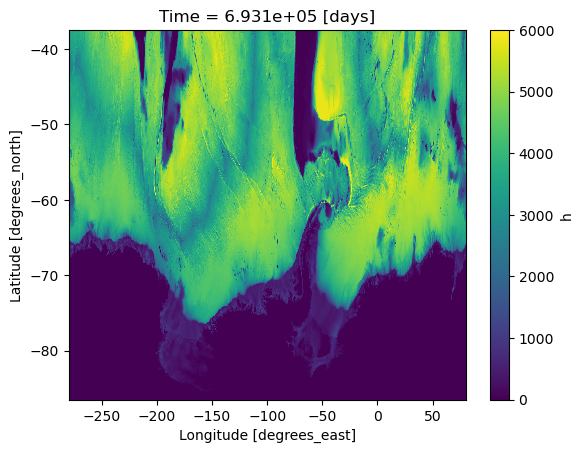

In [13]:
IceShelf_IC.h.sum('Layer').isel(Time = 0).plot()

## make mask of minimum 5 m ocean thickness to get rid of grounding line
THis is essential for initialising in ALE mode

May vary if you change the T/S initial codnitions or eqn of state, since then the density will vary.

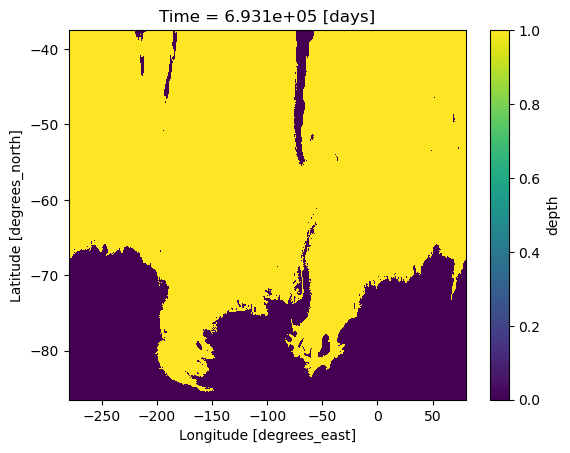

In [14]:
thin_ocean_mask = (topog.copy().sel(ny = np.arange(1442)).depth.where(IceShelf_IC.h.sum('Layer').isel(Time = 0).rename({'lath':'ny','lonh':'nx'})>5)*0+1).fillna(0)
thin_ocean_mask.plot()

### Fill unconnected cells in this ocean mask

In [17]:
## fill thin_ocean_mask

#%%time

# manually do deseas on ocean_mask

# we only care about south of 37S, and our chosen latitude cut off is index 1442
small_mask = thin_ocean_mask

#start at left and right side of domain (check it is ocean = value 1)
print(small_mask[-1,0])
print(small_mask[-1,-1])

# document a variable to say I've already checked this point
working_out_mask = np.zeros_like(small_mask)
working_out_mask[-1,0] = 1
working_out_mask[-1,1] = 1
working_out_mask[-2,0] = 1
working_out_mask[-2,1] = 1

# filled mask which is 1 if ocena and connected to say I've already checked this point
filled_mask = np.zeros_like(small_mask)
filled_mask[-1,0] = 1
filled_mask[-1,1] = 1
filled_mask[-2,0] = 1
filled_mask[-2,1] = 1

#also start a line in the middle to speed it up
filled_mask[1050,:] = 1
working_out_mask[1050,:] = 1
#check this latitude circle is all ocean (it is if print statement is 1)
print(np.min(small_mask[1050,:]))

#reset counter of number of working_out_mask cells
sum_ocean = 0

for i in np.arange(35):
    print('iteration ',i)
    # work north-east, and north-west, north of ocean line
    # then work south-east, and south-west, south of ocean line
    
    for jjs in np.arange(1050,1441):
        for iis in np.arange(1,4319):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        # do boundaries individually for indexing reasons
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        
    for jjs in np.arange(1050,1441):
        for iis in np.arange(4318,0,-1):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
    # now do top
    jjs = 1441
    for iis in np.arange(1,4319):
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1)  or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
    iis = 0
    if working_out_mask[jjs,iis] == 0:
        # if neighbouring existing is filled mask
        if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
            filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
            #print('yooo')
        # update to say it has been checked
            working_out_mask[jjs,iis] = 1
    iis = 4319
    if working_out_mask[jjs,iis] == 0:
        # if neighbouring existing is filled mask
        if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
            filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
            #print('yooo')
        # update to say it has been checked
            working_out_mask[jjs,iis] = 1
            
    # then work south-east, and south-west, south of ocean line

    for jjs in np.arange(1049,1,-1):
        for iis in np.arange(1,4319):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
    for jjs in np.arange(1049,1,-1):
        for iis in np.arange(4318,0,-1):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
                    
    print(np.sum(working_out_mask)) # if this number is constant then have converged (no more connected cells)

    if (np.sum(working_out_mask) == sum_ocean):
        print('convergence achieved yay')
        break
    else:
        sum_ocean = np.sum(working_out_mask)


<xarray.DataArray 'depth' ()> Size: 4B
array(1., dtype=float32)
Coordinates:
    ny       float64 8B -37.5
    nx       float64 8B -280.0
    Time     float64 8B 6.931e+05
<xarray.DataArray 'depth' ()> Size: 4B
array(1., dtype=float32)
Coordinates:
    ny       float64 8B -37.5
    nx       float64 8B 79.96
    Time     float64 8B 6.931e+05
<xarray.DataArray 'depth' ()> Size: 8B
array(1.)
Coordinates:
    ny       float64 8B -58.79
    Time     float64 8B 6.931e+05
iteration  0
3655511.0
iteration  1
3661403.0
iteration  2
3663101.0
iteration  3
3664245.0
iteration  4
3665214.0
iteration  5
3665873.0
iteration  6
3666306.0
iteration  7
3666589.0
iteration  8
3666784.0
iteration  9
3666929.0
iteration  10
3667047.0
iteration  11
3667119.0
iteration  12
3667193.0
iteration  13
3667246.0
iteration  14
3667286.0
iteration  15
3667317.0
iteration  16
3667341.0
iteration  17
3667360.0
iteration  18
3667384.0
iteration  19
3667402.0
iteration  20
3667421.0
iteration  21
3667438.0
iteration  2

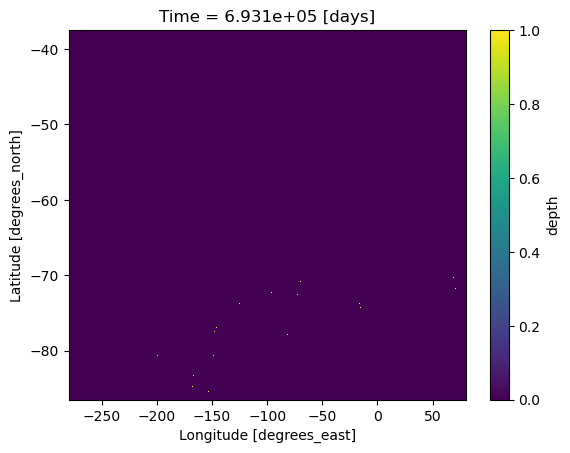

In [19]:
(thin_ocean_mask - filled_mask).plot()

In [20]:
(thin_ocean_mask - filled_mask).sum().values

array(1021., dtype=float32)

## Save ocean topo and ocean mask

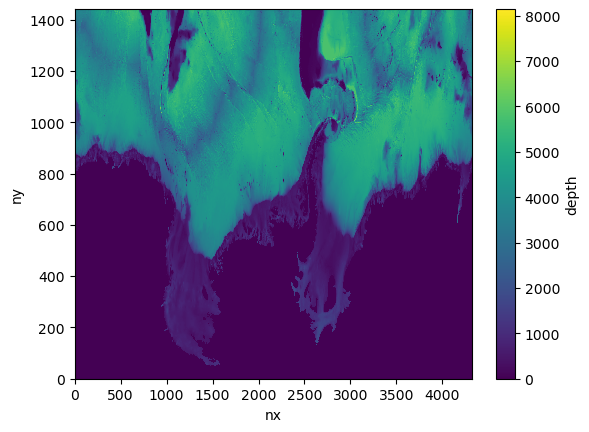

In [22]:
topog_noGL = topog.copy().sel(ny = np.arange(1442))
topog_noGL["depth"] = topog_noGL.depth.where(filled_mask>0).fillna(0)
topog_noGL.depth.plot()
topog_noGL.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb. Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits and no isolated seas removal.'}
topog_noGL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/topog_Charrassin_open_cavity_noGL5m_new150925.nc")


/jobfs/149706477.gadi-pbs/ipykernel_946833/3147396958.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mask = mask.drop("depth")


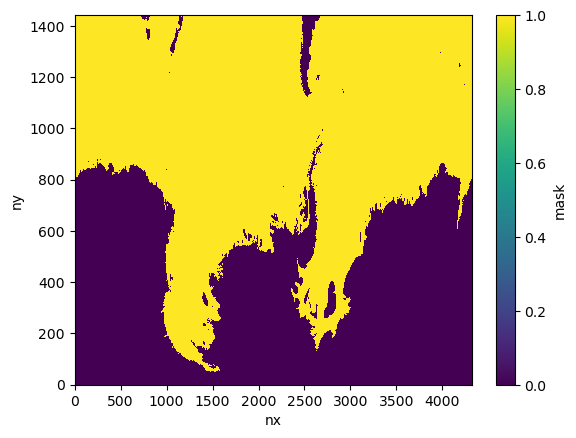

In [27]:

mask = topog_noGL.copy()
mask["mask"] = mask.depth*0+filled_mask
mask = mask.drop("depth")
mask.mask.plot()
mask.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb. Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits. Isolated seas are removed. Masked out nonzero values.'}
mask.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/mask_Charrassin_open_cavity_noGL5m_new150925.nc")

## Repeat for sea ice

sea ice = ocean but where ice sheet surface eleveation = 0

Also get rid of unconnected cells.

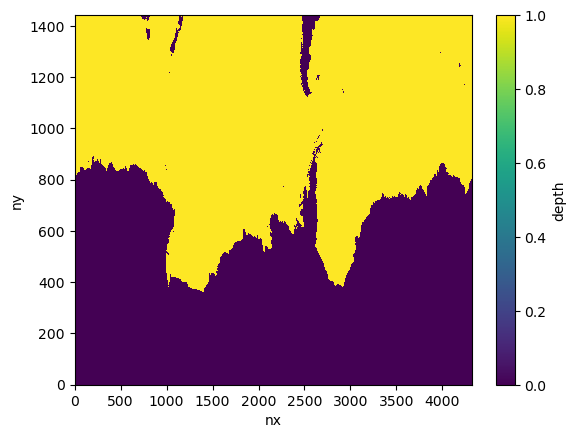

In [28]:
## define sea ice to be topog except zero where surface elevation > 0
topog_sea_ice = topog_noGL.copy()
topog_sea_ice["depth"] = topog_sea_ice.depth.where(surface.elevation.sel(ny = np.arange(1442))==0).fillna(0)
#topog_sea_ice["depth"] = topog_sea_ice.depth.where(topog_sea_ice.depth > 0).fillna(0)

## sea ice mask, fill unconnected cells.
sea_ice_mask = (topog_sea_ice.depth.where(topog_sea_ice.depth>0)*0+1).fillna(0)
sea_ice_mask.plot()

In [29]:
## fill thin_ocean_mask

#%%time

# manually do deseas on ocean_mask

# we only care about south of 37S, and our chosen latitude cut off is index 1442
small_mask = sea_ice_mask

#start at left and right side of domain (check it is ocean = value 1)
print(small_mask[-1,0])
print(small_mask[-1,-1])

# document a variable to say I've already checked this point
working_out_mask = np.zeros_like(small_mask)
working_out_mask[-1,0] = 1
working_out_mask[-1,1] = 1
working_out_mask[-2,0] = 1
working_out_mask[-2,1] = 1

# filled mask which is 1 if ocena and connected to say I've already checked this point
filled_mask = np.zeros_like(small_mask)
filled_mask[-1,0] = 1
filled_mask[-1,1] = 1
filled_mask[-2,0] = 1
filled_mask[-2,1] = 1

#also start a line in the middle to speed it up
filled_mask[1050,:] = 1
working_out_mask[1050,:] = 1
#check this latitude circle is all ocean (it is if print statement is 1)
print(np.min(small_mask[1050,:]))

#reset counter of number of working_out_mask cells
sum_ocean = 0

for i in np.arange(35):
    print('iteration ',i)
    # work north-east, and north-west, north of ocean line
    # then work south-east, and south-west, south of ocean line
    
    for jjs in np.arange(1050,1441):
        for iis in np.arange(1,4319):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        # do boundaries individually for indexing reasons
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        
    for jjs in np.arange(1050,1441):
        for iis in np.arange(4318,0,-1):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
    # now do top
    jjs = 1441
    for iis in np.arange(1,4319):
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1)  or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
    iis = 0
    if working_out_mask[jjs,iis] == 0:
        # if neighbouring existing is filled mask
        if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
            filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
            #print('yooo')
        # update to say it has been checked
            working_out_mask[jjs,iis] = 1
    iis = 4319
    if working_out_mask[jjs,iis] == 0:
        # if neighbouring existing is filled mask
        if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
            filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
            #print('yooo')
        # update to say it has been checked
            working_out_mask[jjs,iis] = 1
            
    # then work south-east, and south-west, south of ocean line

    for jjs in np.arange(1049,1,-1):
        for iis in np.arange(1,4319):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
    for jjs in np.arange(1049,1,-1):
        for iis in np.arange(4318,0,-1):
            if working_out_mask[jjs,iis] == 0:
                # if neighbouring existing is filled mask
                if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1) or (filled_mask[jjs,iis+1] ==1):
                    filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                    #print('yooo')
                # update to say it has been checked
                    working_out_mask[jjs,iis] = 1
        iis = 0
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis+1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
        iis = 4319
        if working_out_mask[jjs,iis] == 0:
            # if neighbouring existing is filled mask
            if (filled_mask[jjs-1,iis] ==1) or (filled_mask[jjs+1,iis] ==1) or (filled_mask[jjs,iis-1] ==1):
                filled_mask[jjs,iis]= small_mask[jjs,iis] #0 is land 1 is ocean
                #print('yooo')
            # update to say it has been checked
                working_out_mask[jjs,iis] = 1
                    
    print(np.sum(working_out_mask)) # if this number is constant then have converged (no more connected cells)

    if (np.sum(working_out_mask) == sum_ocean):
        print('convergence achieved yay')
        break
    else:
        sum_ocean = np.sum(working_out_mask)


<xarray.DataArray 'depth' ()> Size: 4B
array(1., dtype=float32)
<xarray.DataArray 'depth' ()> Size: 4B
array(1., dtype=float32)
<xarray.DataArray 'depth' ()> Size: 8B
array(1.)
iteration  0
3337128.0
iteration  1
3338621.0
iteration  2
3339166.0
iteration  3
3339467.0
iteration  4
3339613.0
iteration  5
3339721.0
iteration  6
3339812.0
iteration  7
3339874.0
iteration  8
3339923.0
iteration  9
3339937.0
iteration  10
3339947.0
iteration  11
3339954.0
iteration  12
3339971.0
iteration  13
3339980.0
iteration  14
3339987.0
iteration  15
3339987.0
convergence achieved yay


## Save sea ice topo and sea ice mask and sea ice kmt (same data, different name)

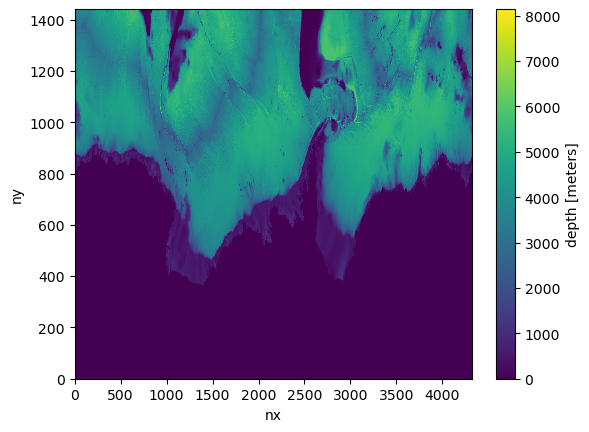

In [32]:
topog_sea_ice = topog_sea_ice.where(filled_mask>0).fillna(0)
topog_sea_ice.depth.attrs = {'units':"meters"}
topog_sea_ice.attrs = {'description':'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits. Isolated seas are removed. Set to zero where ice surface elevation > 0.'}

topog_sea_ice.depth.plot()
topog_sea_ice.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/topog_Charrassin_sea_ice_from_iceelev_new150925.nc")

/jobfs/149706477.gadi-pbs/ipykernel_946833/3070095649.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mask_sea_ice = mask_sea_ice.drop("depth")
/jobfs/149706477.gadi-pbs/ipykernel_946833/3070095649.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mask_sea_ice = mask_sea_ice.drop("depth")


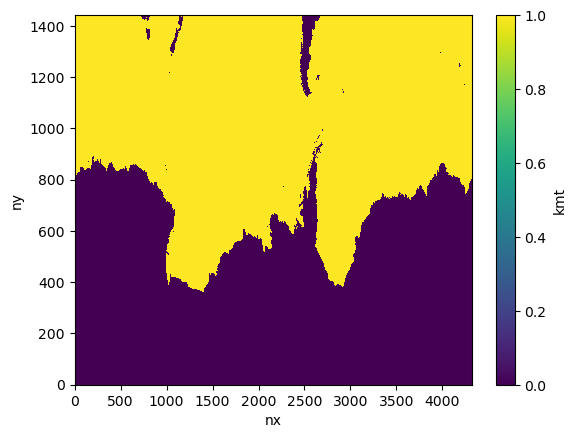

In [37]:
mask_sea_ice = topog_sea_ice.copy()
mask_sea_ice["kmt"] = mask_sea_ice.depth*0 + filled_mask
mask_sea_ice = mask_sea_ice.drop("depth")
mask_sea_ice.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits. Isolated seas are removed. Set to zero where ice surface elevation > 0. Masked to find kmt with nonzero values.'}
mask_sea_ice.kmt.plot()
mask_sea_ice.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/kmt_Charrassin_sea_ice_from_iceelev_new150925.nc")
mask_sea_ice = topog_sea_ice.copy()
mask_sea_ice["mask"] = mask_sea_ice.depth*0 + filled_mask
mask_sea_ice = mask_sea_ice.drop("depth")
mask_sea_ice.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits. Isolated seas are removed. Set to zero where ice surface elevation > 0. Masked to find mask with nonzero values.'}
mask_sea_ice.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/mask_Charrassin_sea_ice_from_iceelev_new150925.nc")

## Make ice shelf file

area everywhere file needed
and mask ocean and mask sea ice

Define ice shelf to be ocean mask - sea ice mask residual (varies slightly from surface elevation criteria due to the removal of unconnected cells in sea ice file. So there will be a few open ocean regions that become ice-shelf covered).

In [38]:
area = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km-SIS2/area_everywhere.nc')
mask_ocean = xr.open_dataset("/g/data/x77/cy8964/mom6/input/input-8km/150925/mask_Charrassin_open_cavity_noGL5m_new150925.nc")
mask_seaice = xr.open_dataset("/g/data/x77/cy8964/mom6/input/input-8km/150925/mask_Charrassin_sea_ice_from_iceelev_new150925.nc")

#area should now be everywhere where mask_ocean = 1 but mask_seaice = 0
# so surface elevation var used in sea ice mask but not here

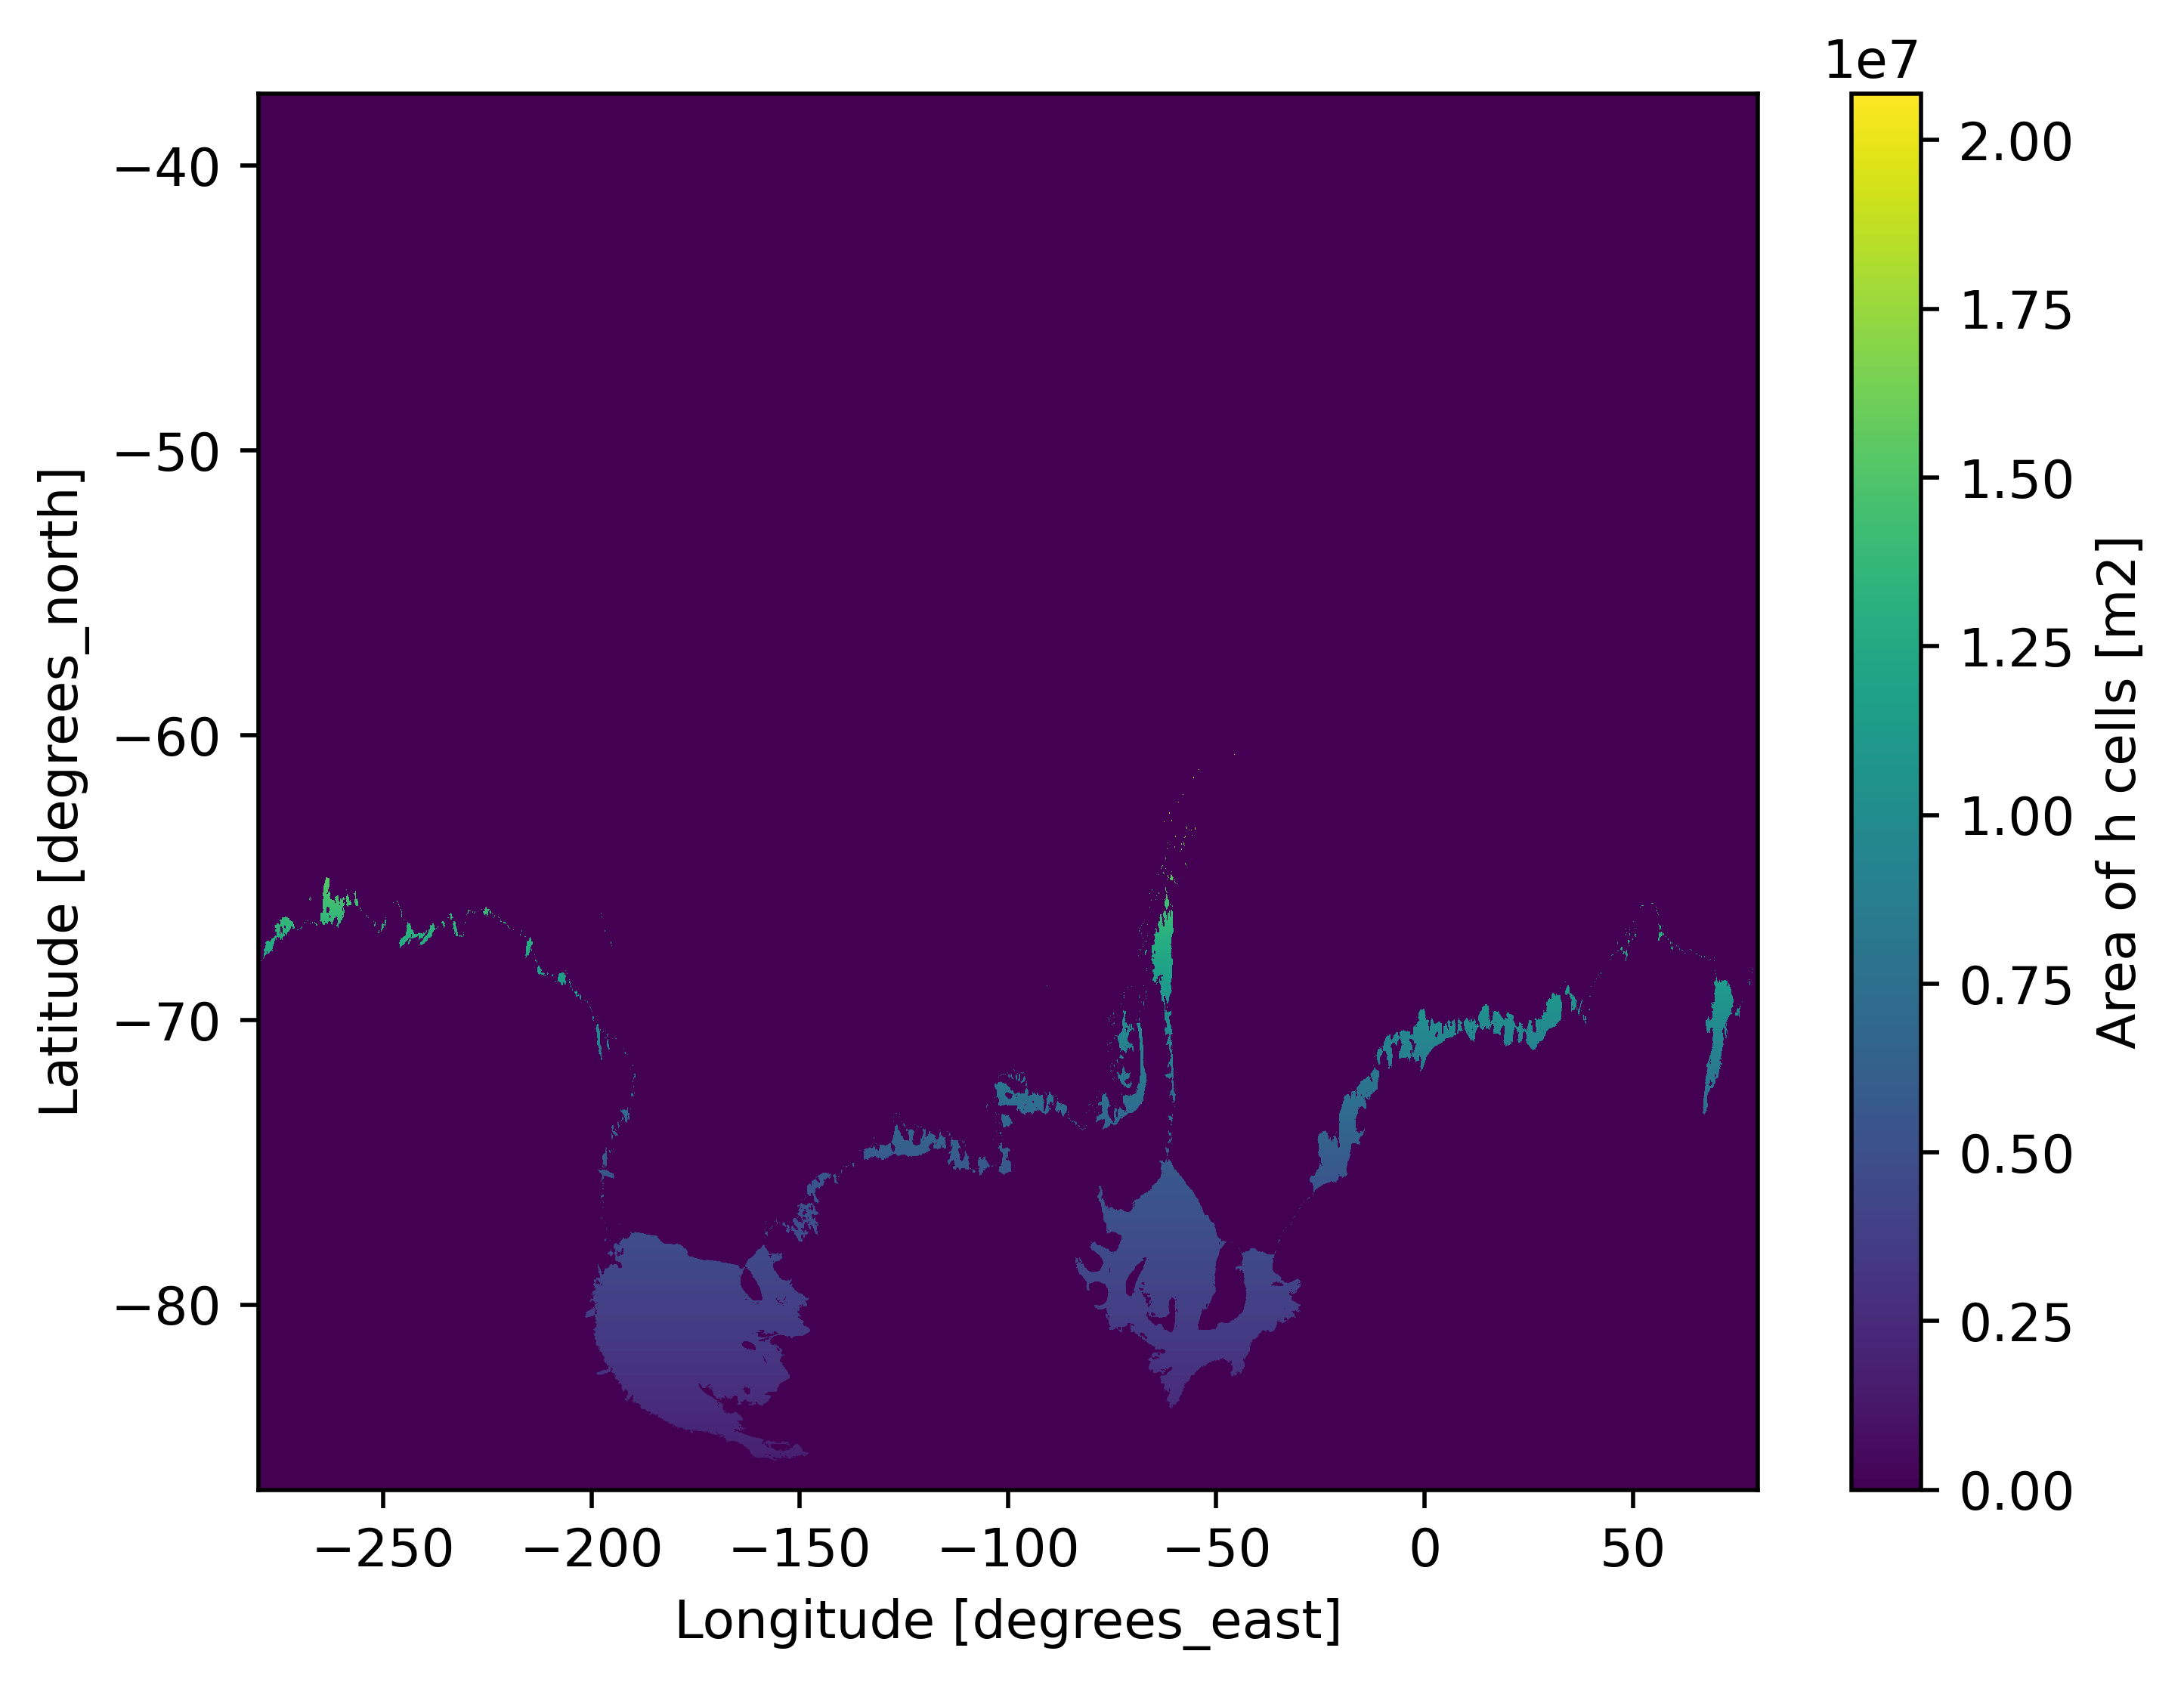

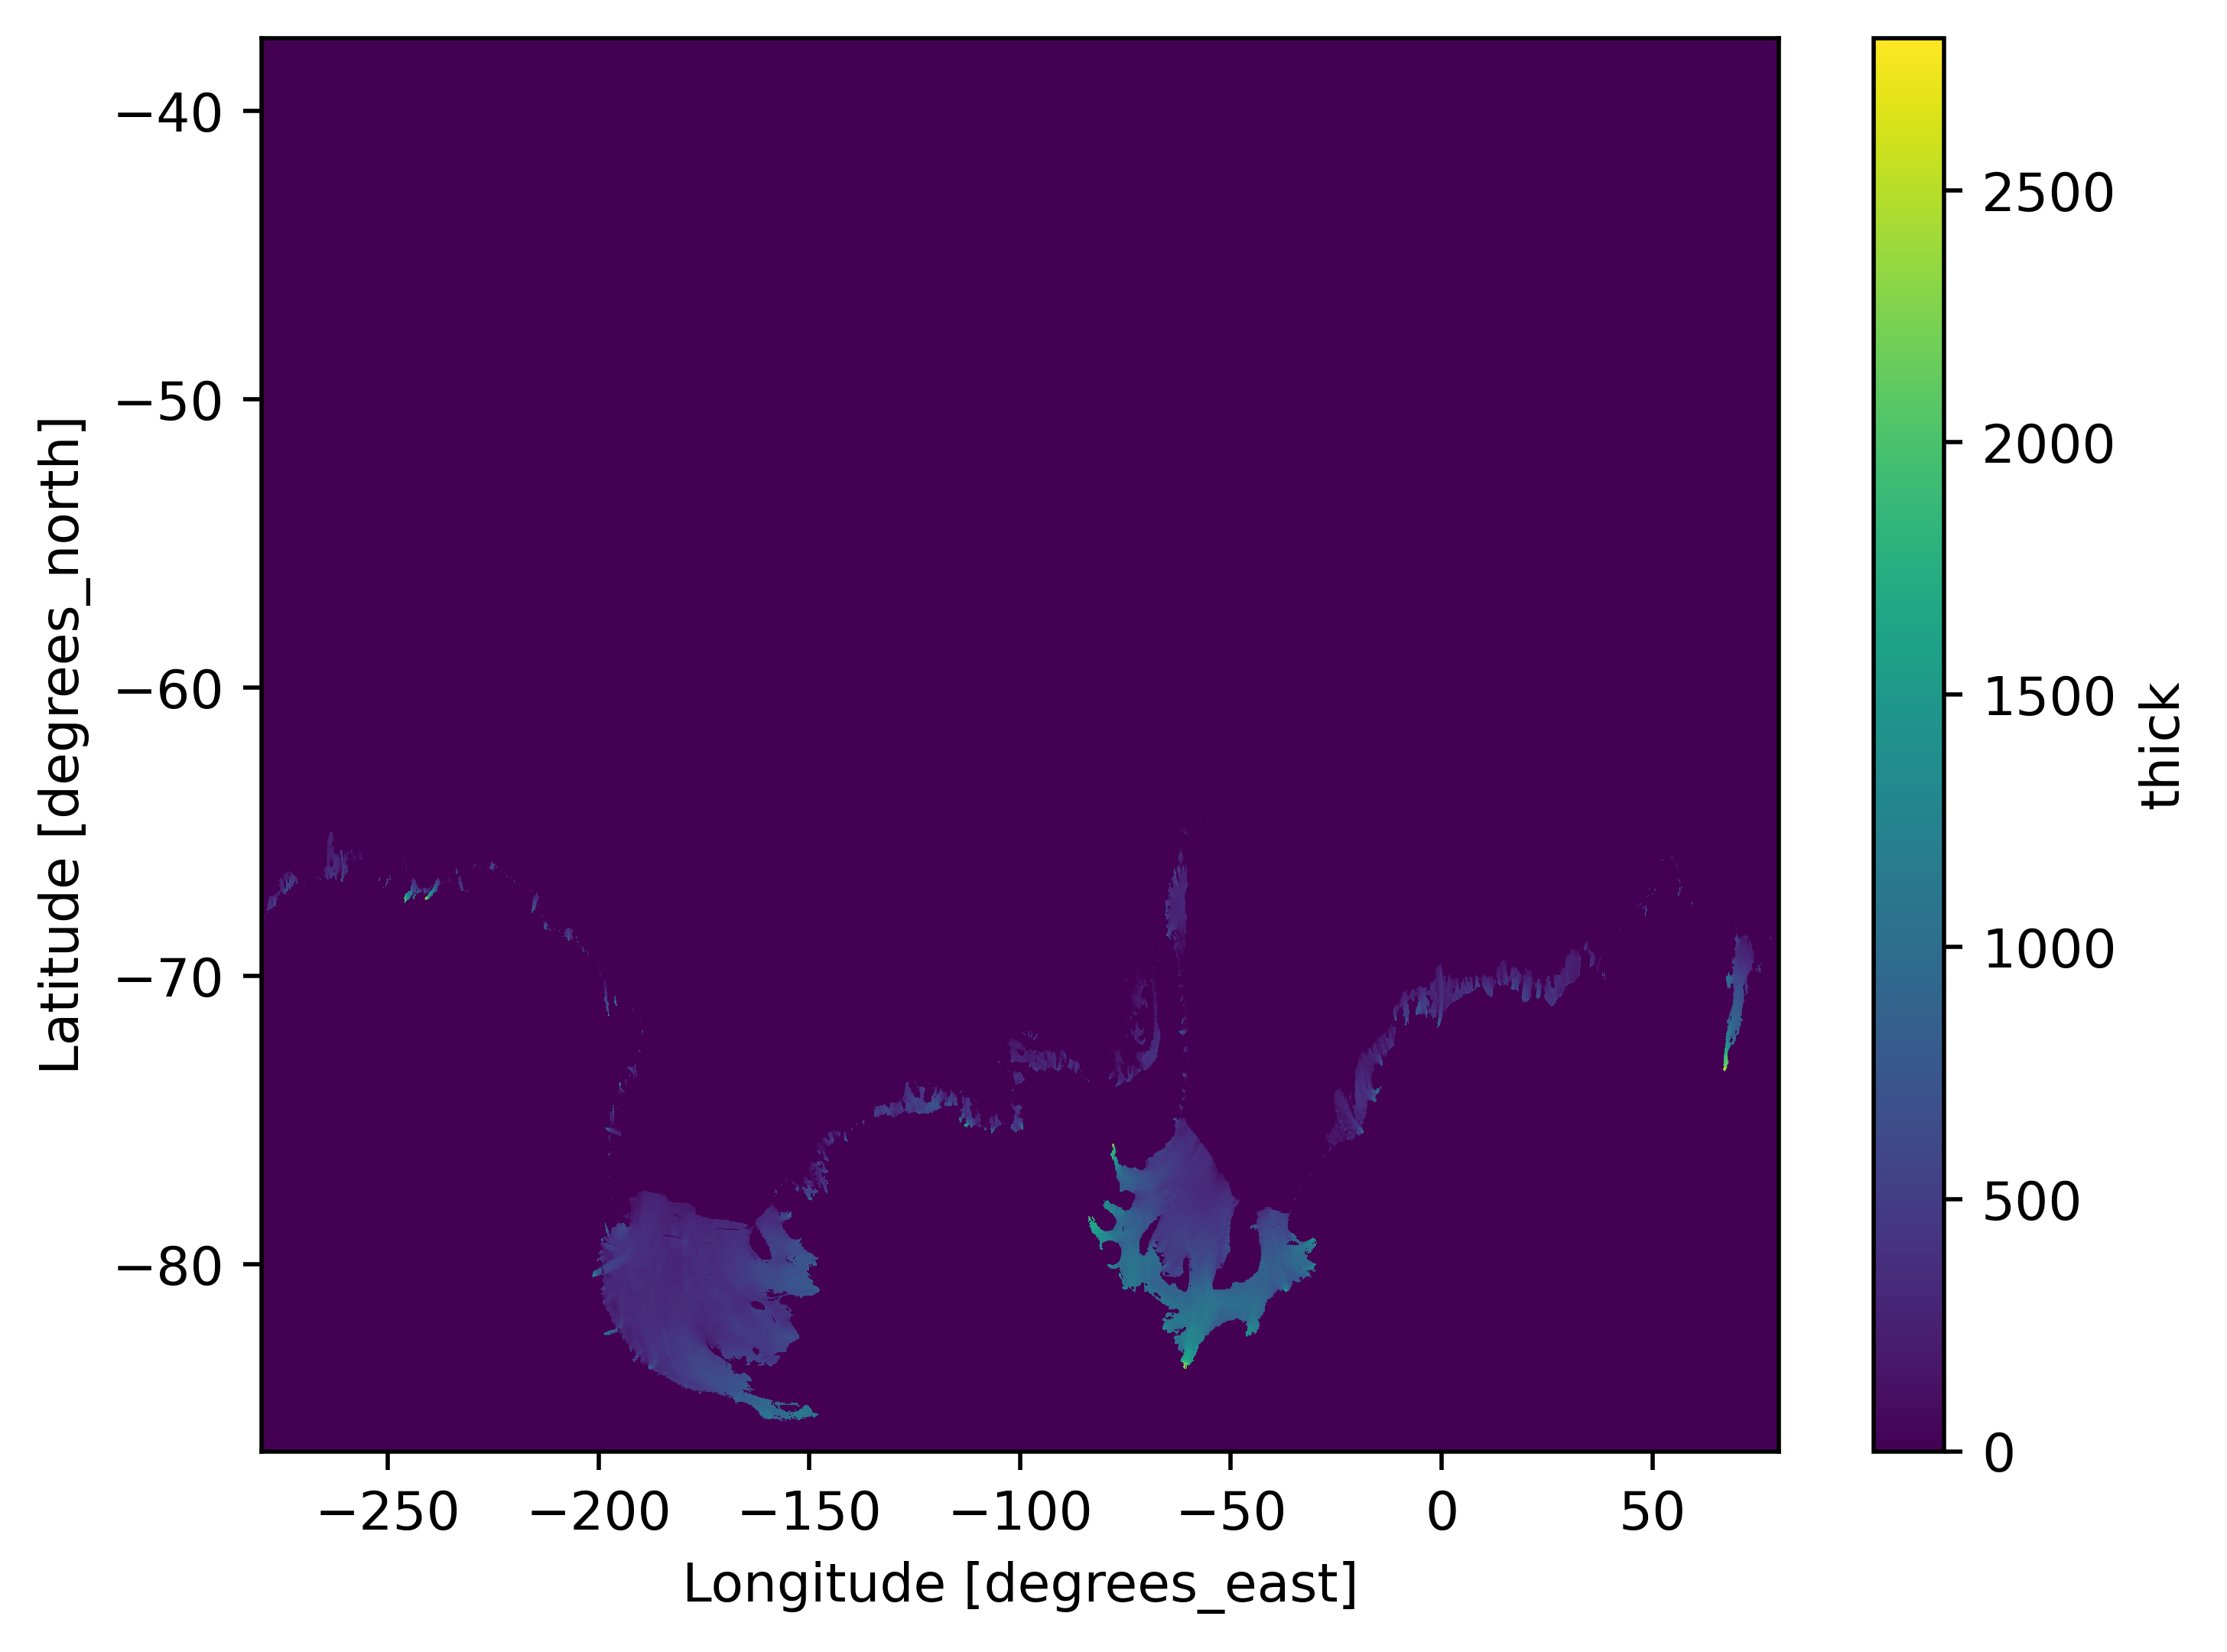

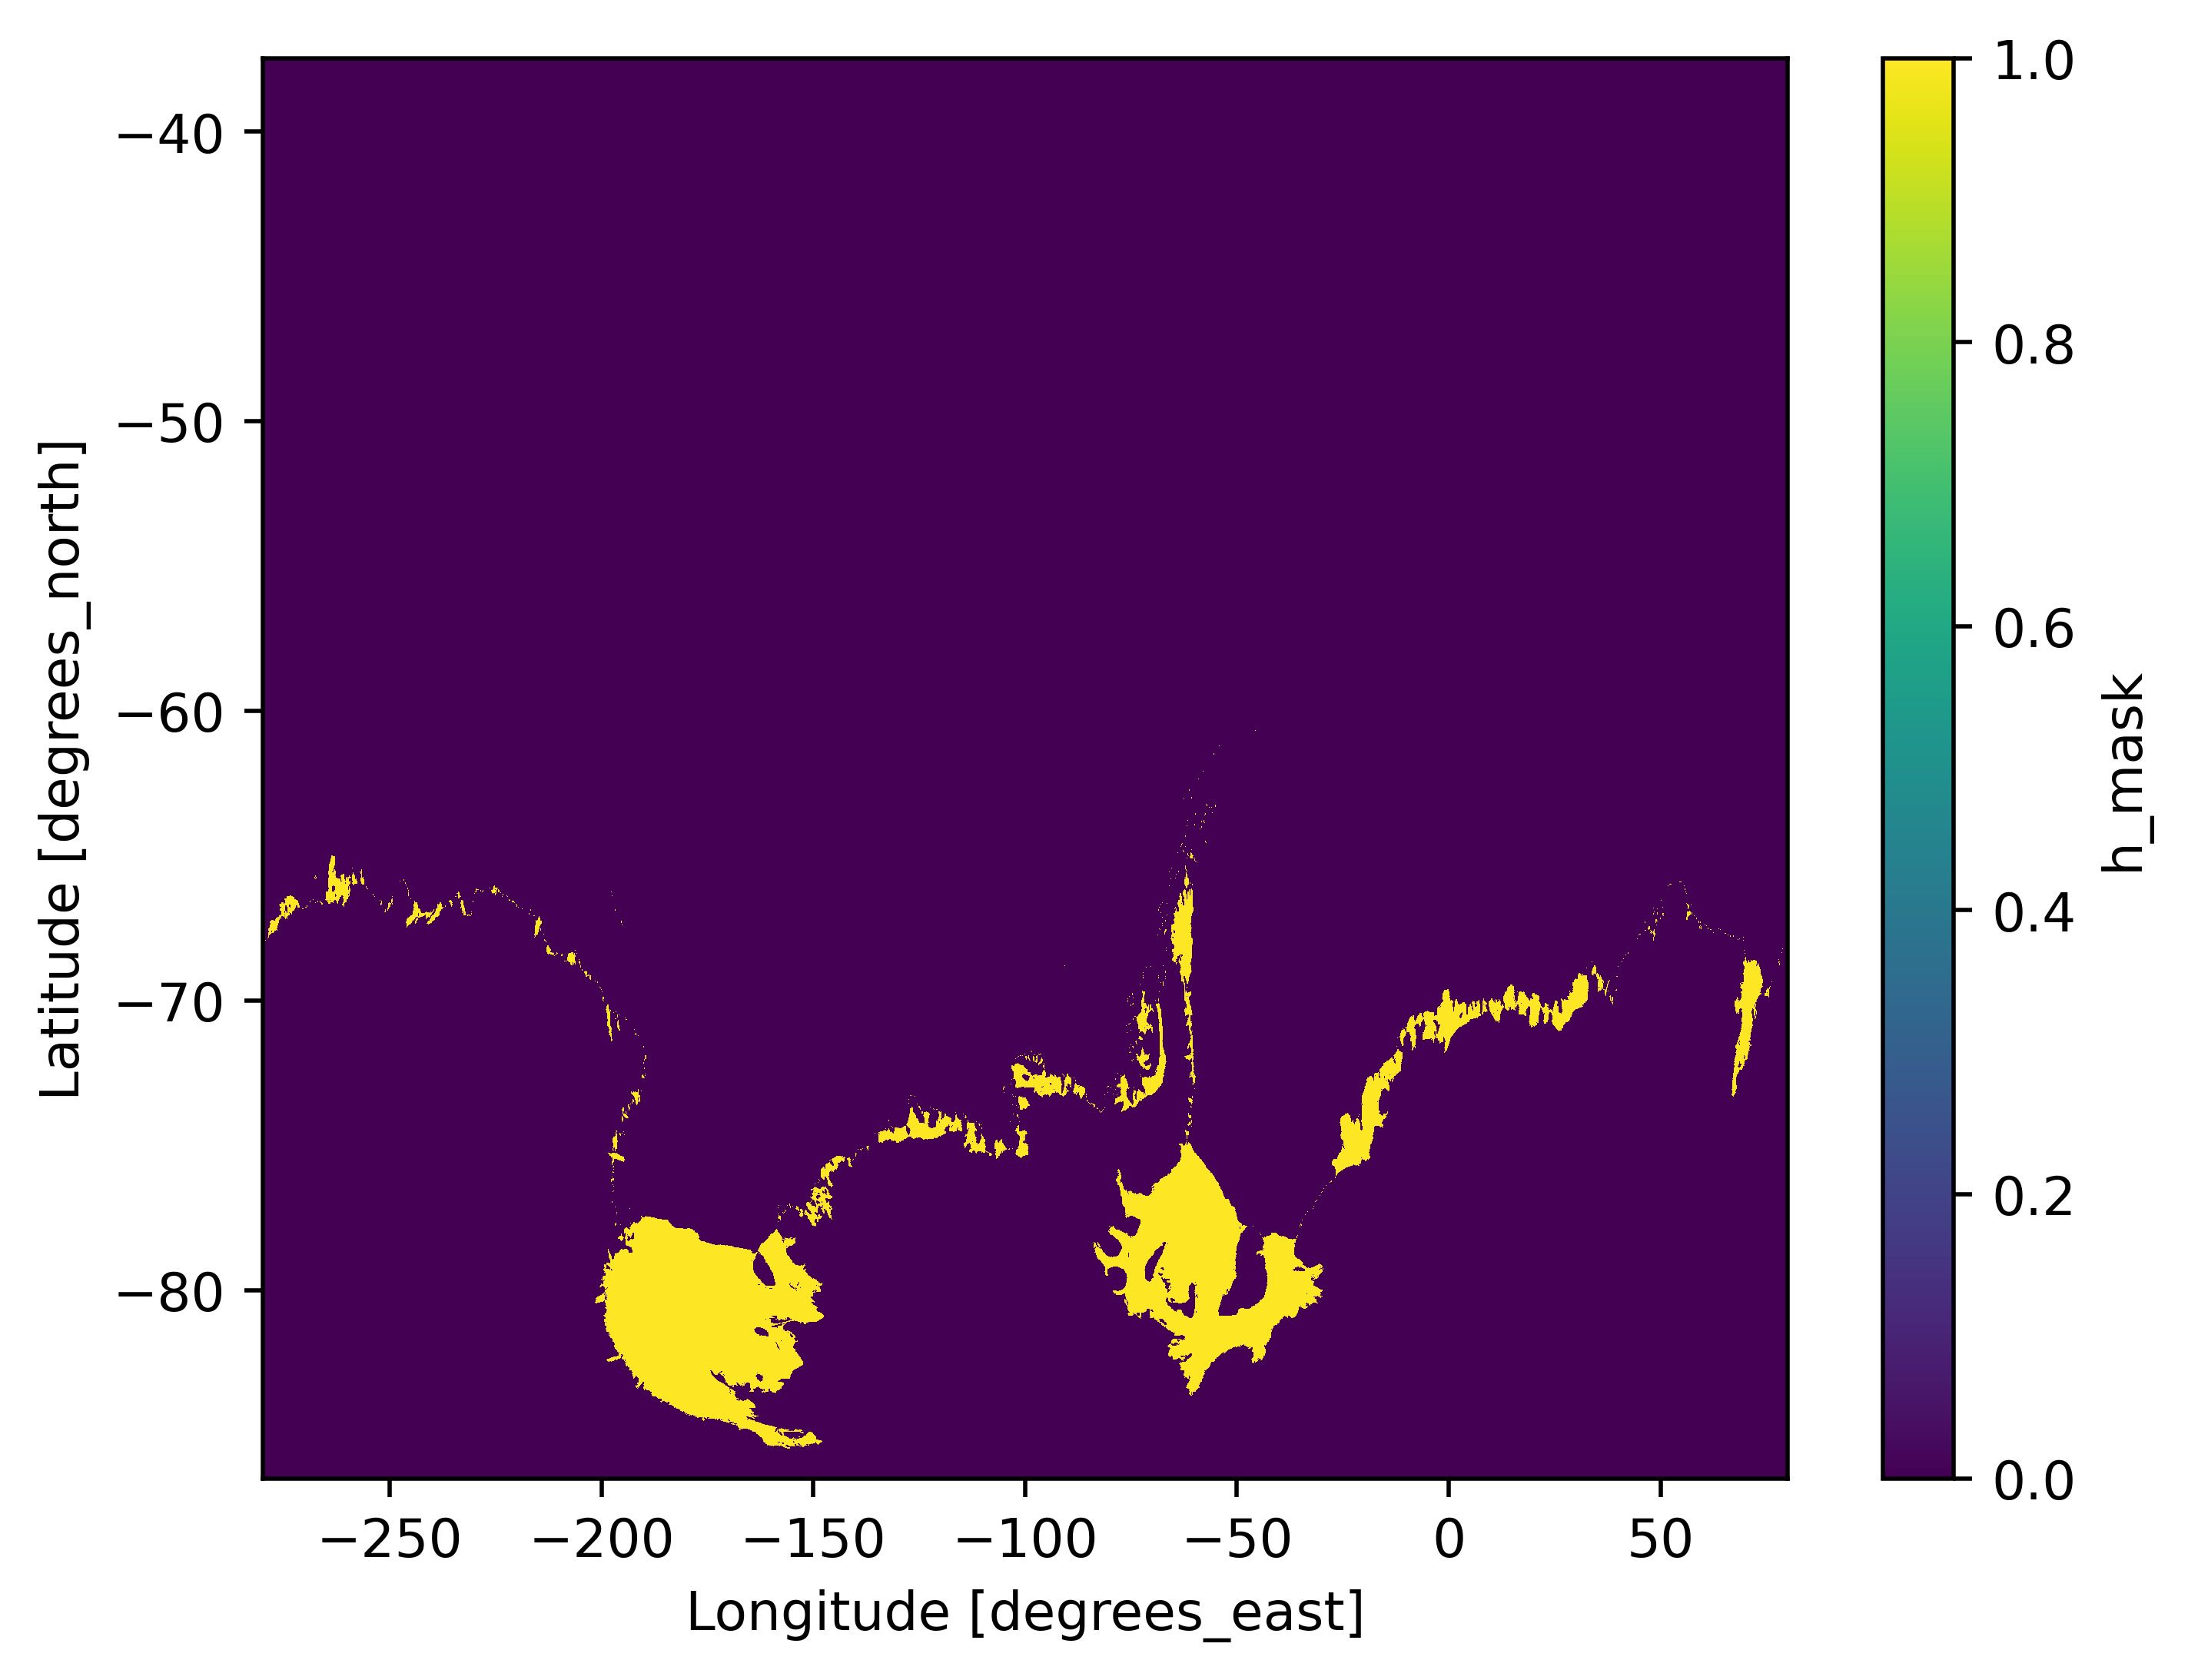

In [41]:
ice_thick_area_GL = ice_thick.copy().sel(ny = np.arange(1442))
mask_ice = mask_ocean.mask - mask_seaice.mask
ice_thick_area_GL["area"] = area.Ah.rename({'lath':'ny','lonh':'nx'}).where(mask_ice>0).fillna(0)
# otherwise does it put ice on islands/ice free continents:????
#ice_thick_area_GL["area"] = ice_thick_area_GL.area.where(mask_ice>0).fillna(0)
ice_thick_area_GL["h_mask"] = (ice_thick_area_GL.area.where(ice_thick_area_GL.area>0)*0+1).fillna(0)
ice_thick_area_GL["h_mask"] = ice_thick_area_GL.h_mask.where(mask_ice>0).fillna(0)
ice_thick_area_GL["thick"] = ice_thick_area_GL.thick.where(mask_ice>0).fillna(0)
#make thickness agree with the others
ice_thick_area_GL["thick"] = ice_thick_area_GL.thick + (ice_thick_area_GL.thick.where((ice_thick_area_GL.thick ==0) & (ice_thick_area_GL.h_mask ==1))*0+1e-6).fillna(0)
ice_thick_area_GL.attrs = {'description':'Ice thickness (meters), float, 0 to 5000 meters. From Charrassin 2025 depth regridded onto 8km grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb. Area added using ocean_geometry output of test ocean with depth 6000m. Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. Thickness filled to be 1e-6 where thick=0 but elevation > 0. h_mask and area uses where elevation > 0.'}

fig = plt.figure(dpi = 500)
ice_thick_area_GL.area.plot()
plt.show()
fig = plt.figure(dpi = 500)
ice_thick_area_GL.thick.plot()
plt.show()
fig = plt.figure(dpi = 500)
ice_thick_area_GL.h_mask.plot()
plt.show()

ice_thick_area_GL.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/150925/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_ADDHMASKFILLTHICK_150925.nc")


# Make nuopc files

```
/home/156/cy8964/model-tools/make_OM3_8k_topo/gen_masks_Charrassin_ice_topo_150925.sh
```

```
#!/usr/bin/env sh
# Copyright 2025 ACCESS-NRI and contributors. See the top-level COPYRIGHT file for details.
# SPDX-License-Identifier: Apache-2.0

#PBS -q normal
#PBS -l walltime=4:00:00,mem=10GB
#PBS -l wd
#PBS -l storage=gdata/hh5+gdata/ik11+gdata/tm70+gdata/vk83+gdata/x77

# Input files - Using the environment variables passed via -v
INPUT_HGRID=$INPUT_HGRID
INPUT_VGRID=$INPUT_VGRID
INPUT_GBCO=$INPUT_GBCO
# Minimum allowed y-size for a cell (in m)
CUTOFF_VALUE=6000
# Output filenames
ESMF_MESH_FILE='access-om3-8km-ESMFmesh.nc'
ESMF_NO_MASK_MESH_FILE='access-om3-8km-nomask-ESMFmesh.nc' 
ROF_WEIGHTS_FILE='access-om3-8km-rof-remap-weights.nc'

# Build bathymetry-tools
./build.sh

module purge
module use /g/data/hh5/public/modules
module load conda/analysis3
module load nco

set -x #print commands to e file
set -e #exit on error

python3 /home/156/cy8964/model-tools/om3-scripts/mesh_generation/generate_mesh.py --grid-type=mom --grid-filename=/g/data/x77/cy8964/mom6/input/input-8km/ocean_hgrid_cropped.nc --mesh-filename=/g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-ESMFmesh_Charrassin_nocavity_cropped.nc --mask-filename=/g/data/x77/cy8964/mom6/input/input-8km/150925/mask_Charrassin_sea_ice_from_iceelev_new150925.nc --wrap-lons

python3 /home/156/cy8964/model-tools/om3-scripts/mesh_generation/generate_mesh.py --grid-type=mom --grid-filename=/g/data/x77/cy8964/mom6/input/input-8km/ocean_hgrid_cropped.nc --mesh-filename=/g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-nomask-ESMFmesh_Charrassin_nocavity_cropped.nc --wrap-lons

python3 ./om3-scripts/mesh_generation/generate_rof_weights.py --mesh_filename=/g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-ESMFmesh_Charrassin_nocavity_cropped.nc --weights_filename=/g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-rof-remap-weights_Charrassin_nocavity_cropped.nc

```

```
input:
    - /g/data/x77/cy8964/mom6/input/input-8km/150925/kmt_Charrassin_sea_ice_from_iceelev_new150925.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/ocean_hgrid_cropped.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/ocean_vgrid_cropped.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/salt_restore_interpolated_nearest.nc
    - /g/data/x77/cy8964/mom6/input/input-8km/150925/topog_Charrassin_sea_ice_from_iceelev_new150925.nc
    - /g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-ESMFmesh_Charrassin_nocavity_cropped.nc      
    - /g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-nomask-ESMFmesh_Charrassin_nocavity_cropped.nc      
    - /g/data/vk83/configurations/inputs/access-om3/share/meshes/share/2024.09.16/JRA55do-datm-ESMFmesh.nc
    - /g/data/vk83/configurations/inputs/access-om3/share/meshes/share/2024.09.16/JRA55do-drof-ESMFmesh.nc
    - /g/data/x77/cy8964/mom6/input/input-8km/150925/access-om3-8km-rof-remap-weights_Charrassin_nocavity_cropped.nc
    - /g/data/vk83/experiments/inputs/JRA-55/RYF/v1-4/data
    - /g/data/tm70/cy8964/mom6/input/input-8km/forcing_access_yr2_8km_fill.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/diag_rho2.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/bottom_roughness_Charrassin_nocavity_cropped.nc
    - /g/data/tm70/cy8964/mom6/input/input-8km/tideamp_Charrassin_nocavity_cropped.nc
    - /g/data/x77/cy8964/mom6/input/input-8km/150925/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_ADDHMASKFILLTHICK_150925.nc

```

# Salt restoring mask based on 1000m isobath

Contour made by  Wilton with https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/evaluation/Cross-contour_transport-analysis-notebook.ipynb

In [3]:
isobath = np.load('/g/data/x77/wf4500/MOM6_panan_ice_shelf/GH/mom6-panAn-iceshelf-tools/evaluation/isobath_1000m_8km_jra_ryf_obc_Charrassin.npz')

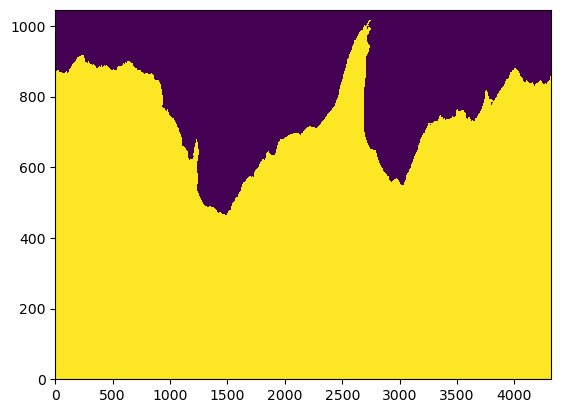

In [4]:
plt.pcolormesh(isobath['shelf_mask'])

In [5]:
eg_ocean_mask = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/150925/mask_Charrassin_sea_ice_from_iceelev_new150925.nc')
salt_restoring_mask = eg_ocean_mask.copy()
# 1 means restore, 0 means not

In [6]:
print(isobath['shelf_mask'].shape)
print(salt_restoring_mask.mask.shape)

(1046, 4320)
(1442, 4320)


(1442, 4320)


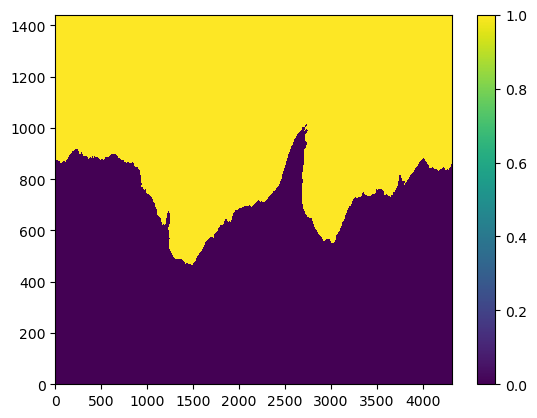

In [11]:
big_isobath_mask = 1-np.pad(isobath['shelf_mask'],((0,1442-1046),(0,0)),'constant',constant_values = 0)
print(big_isobath_mask.shape)
plt.pcolormesh(big_isobath_mask)
plt.colorbar()

In [13]:
salt_restoring_mask.attrs = {'description': 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb.  Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits. Isolated seas are removed. Set to zero where ice surface elevation > 0. Masked to find mask with nonzero values. Then turned into salt restoring mask with 1000m isobath using mask in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/evaluation/Cross-contour_transport-analysis-notebook.ipynb'}

In [21]:
salt_restoring_mask["mask"] = salt_restoring_mask.mask*0 + big_isobath_mask
salt_restoring_mask

salt_restoring_mask.to_netcdf('/g/data/x77/cy8964/mom6/input/input-8km/150925/salt_restore_mask.nc')
